## Exploratory Data Visualization Part 2
### Multivariate Exploration

In [2]:
#import needed packages
import pandas as pd    # For database management
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import io
import csv

%matplotlib inline

In [3]:
#We start saving plots in plots sub folder from working directory
folder_plots = 'plots'
if not os.path.exists(folder_plots):
    os.makedirs(folder_plots)

In [6]:
df_plt = pd.read_csv('master_data.csv',low_memory=False)
#if want to run for test the data available in Github is only 75k records and uncomment the below.
#df_plt = pd.read_csv('master_75k.csv',low_memory=False)

In [7]:
data = df_plt.copy()
data = data.query('minimum_distance_miles > 0 & member_gender !="Other"')

xlim_max = 4.0
bins = np.around(np.arange(0.1,xlim_max,0.2),decimals=2).tolist()
data['distance_mile_group'] = pd.cut(data.minimum_distance_miles,bins, \
                                      labels=bins[:-1])

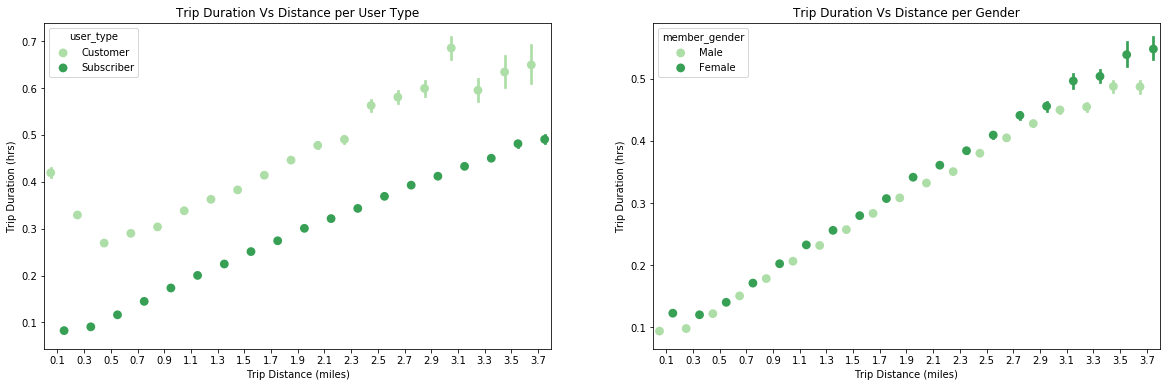

In [8]:
fig, ax = plt.subplots(ncols = 2, figsize = [20,6])
age_group_order = ['10-20','20-30','30-40','40-50','50-60','60-70','70-100','100-140']

sb.pointplot(data=data, x = 'distance_mile_group', y = 'duration_hr', hue = 'user_type',
             palette = 'Greens', linestyles = '', dodge = 0.5, ax = ax[0])

ax[0].set_title('Trip Duration Vs Distance per User Type')
ax[0].set_ylabel('Trip Duration (hrs)')
ax[0].set_xlabel('Trip Distance (miles)')

sb.pointplot(data=data, x = 'distance_mile_group', y = 'duration_hr', hue = 'member_gender',
             palette = 'Greens', linestyles = '', dodge = 0.5, ax = ax[1])

ax[1].set_title('Trip Duration Vs Distance per Gender')
ax[1].set_ylabel('Trip Duration (hrs)')
ax[1].set_xlabel('Trip Distance (miles)')
plt.savefig(folder_plots + '\\'+'Multivariate_Distance_TripDuration_User_Gender.png')
plt.show();

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = [20,6])
age_group_order = ['10-20','20-30','30-40','40-50','50-60','60-70','70-100','100-140']

sb.pointplot(data=data, x = 'member_age_group', y = 'average_speed_mph', hue = 'member_gender',
             palette = 'Greens', linestyles = '', dodge = 0.5, ax = ax[0],order=age_group_order)
ax[0].set_title('Average Speed Vs Age Group by Gender')
ax[0].set_ylabel('Average Speed (mph)')
ax[0].set_xlabel('Member Age Group')

sb.pointplot(data=data, x = 'member_age_group', y = 'average_speed_mph', hue = 'bike_share_for_all_trip',
             palette = 'Greens', linestyles = '', dodge = 0.5, ax = ax[1],order=age_group_order)
ax[1].set_title('Average Speed Vs Age Group by bike share for all trip')
ax[1].set_ylabel('Average Speed (mph)')
ax[1].set_xlabel('Member Age Group')
plt.savefig(folder_plots + '\\'+'Multivariate_Speed_AgeGroup_Gender_share.png')
plt.show();

In [ ]:
folder_plots = 'plots'
plt.figure(figsize = [10, 5])
ax = sb.boxplot(x="city", y="average_speed_mph", hue="user_type",
                 data=df_plt, palette="Set3",order = ['San Francisco','Oakland','San Jose','Other'] )
ax.grid(False)
ax.tick_params(labelsize=12)
ax.set_xlabel("City",fontsize=14,alpha=0.75)
ax.set_ylabel("Average Speed [mph]",fontsize=14,alpha=0.75)
ax.axes.set_title("User Type Distribution",fontsize=16)
plt.savefig(folder_plots + '\\'+'Bivariate_AvgSpeed_User_Type_by_city.png'); 

>It seems that the subscriber average speed is consistently higher than customers in all city, which is expected as casual customers could be new to the area. Worth nothing that San Jose is the slowest for Customer but a bit higher for Subscriber. Need to investigate why this difference assuming the traffic congesion will be the same for all riders.

In [ ]:
plt.figure(figsize = [10, 6])

data = df_plt[df_plt.member_gender.isin(['Male', 'Female'])]

ax = sb.barplot(data = data, x = 'city',y = 'average_speed_mph', hue = 'member_gender')

ax.grid(False)
ax.tick_params(labelsize=12)
ax.set_xlabel("City",fontsize=14,alpha=0.75)
ax.set_ylabel("Average Speed (mph)",fontsize=14,alpha=0.75)
ax.axes.set_title("Member Gender Average Speed",fontsize=16)
plt.savefig(folder_plots + '\\'+'Bivariat_Gender_city_AvgSpeed.png');

Male average speed is generally higher than Female by at least 0.6mph for the three cities.

## Station Geo Data Analysis

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

or using zip() to map lat and long values from start and end station locations

In [ ]:
# create tuples for coordinates 
df_plt['Coordinates_end'] = list(zip(df_plt.end_station_longitude, df_plt.end_station_latitude))
df_plt['Coordinates_start'] = list(zip(df_plt.start_station_longitude, df_plt.start_station_latitude))

#To extract unique station coordinates we dropped any duplicates
df_station_cord = df_plt[['start_station_id','city','Coordinates_start']].drop_duplicates(subset='start_station_id')

#Create points using shapely methods
# We only coordinates_start as coordinates_end correspond to one of the stations location.
df_station_cord['Coordinates_start'] = df_station_cord['Coordinates_start'].apply(Point)

### What are the Top Busiest Stations

>What we manuplating the dataset here are in relation to stations. We also create maps in order to show the representation of the usage of riders.

#### `Busy Hour (BH)` analysis by station

In [ ]:
#this will be used to show in the map but we may need to add city along with colomns for coordinates
df_station_hour = df_plt.groupby(['start_station_id','start_date','start_hour']).agg(
    {'start_hour':np.count_nonzero
    }).rename(columns={'start_hour':'hourly' }).reset_index()

df_station_date_BH  = df_station_hour.groupby(['start_station_id']).agg(
    {'hourly':np.max
    }).reset_index()

#Need to merge with df_station_hour so that start_date and start_hour for BH can be added.
df_station_date_BH = pd.merge(left=df_station_date_BH,right=df_station_hour, how='left',\
                  on=['start_station_id', 'hourly']).drop_duplicates(['start_station_id', 'hourly'])\
.rename(columns={'hourly':'max_rides_BH','start_date':'start_date_BH','start_hour':'start_hour_BH'})
#when found tie numbers only one is used
df_station_date_BH.nlargest(5,'max_rides_BH')

In [ ]:
print("start_station_id of 30 is at ", df_plt[df_plt['start_station_id']==30]['start_station_name'].iloc[0], ", served 71 at a maximum Busy Hour which occur on March 26 of 2019 at 8A.M.")
print("start_station_id of 67 is at ", df_plt[df_plt['start_station_id']==67]['start_station_name'].iloc[0], ", served 70 at a maximum Busy Hour which occur on July 09 of 2018 at 8A.M.")

>The first Top station, start_station_id of 30, San Francisco Caltrain (Townsend St at 4th St) has served 71 riders at a maximum Busy Hour which occur on March 26 of 2019 at 8A.M.

>Second Top station, start_station_id of 67, San Francisco Caltrain Station 2  (Townsend St at 4th St) , served 70 at a maximum Busy Hour which occur on July 09 of 2018 at 8A.M.

####  `Busy Day (BD)` analysis by station

In [ ]:
#group by stations and start_date to find total rides per day for each station
df_station_date = df_plt.groupby(['start_station_id','start_date']).agg(
    {'start_date':np.count_nonzero
    }).rename(columns={'start_date':'date_ride_count' }).reset_index()

#find station maximum number of rides for the busiest day
df_station_BD = df_station_date.groupby(['start_station_id']).agg(
    {'date_ride_count':np.max}).reset_index()

df_station_BD = pd.merge(left=df_station_BD,right=df_station_date, how='left', \
                          on=['start_station_id', 'date_ride_count'])\
.drop_duplicates(['start_station_id', 'date_ride_count']) #when found tie numbers only one is used
df_station_BD = df_station_BD.rename(columns={'date_ride_count':'max_rides_BD','start_date':'start_date_BD'})
df_station_BD.nlargest(5,'max_rides_BD')

In [ ]:
print("start_station_id of 67 is at ", df_plt[df_plt['start_station_id']==67]['start_station_name'].iloc[0], ", served 305 rides at a maximum Busy Day which occur on March 18 of 2019")
print("start_station_id of 58 is at ", df_plt[df_plt['start_station_id']==58]['start_station_name'].iloc[0], ", served 247 rides at a maximum Busy Day which occur on March 13 of 2019")

>First Top station, start_station_id of 67 at San Francisco Caltrain Station 2  (Townsend St at 4th St) , served 305 rides at a maximum Busy Day which occur on March 18 of 2019.

>Second Top station, start_station_id of 58 is at Market St at 10th St , served 247 rides at a maximum Busy Day which occur on March 13 of 2019.

####  `Number of Days Station is in service and Total rides` 

In [ ]:
#stations number of days in service 
df_station_days  = df_station_date.groupby(['start_station_id']).agg(
    {'start_date':['nunique']
    }).rename(columns={'start_date':'station_ndays' }).reset_index()
df_station_days.columns = ["_".join(x) for x in df_station_days.columns.ravel()] 
df_station_days  = df_station_days.rename(columns={'start_station_id_':'start_station_id','station_ndays_nunique':'station_ndays' })

#total number of rides per station
df_station_total  = df_station_date.groupby(['start_station_id']).agg(
    {'date_ride_count':np.sum
    }).rename(columns={'date_ride_count':'station_total' }).reset_index()

#merge number of days and total rides to determine the average number of rides per station
df_station_nDay = pd.merge(left=df_station_days,right=df_station_total, how='left',on=['start_station_id'])
#.drop_duplicates(['start_station_id', 'date_ride_count'])
df_station_nDay['avg_daily'] = df_station_nDay['station_total']/df_station_nDay['station_ndays']
df_station_nDay.nlargest(5,'station_total')

In [ ]:
print("start_station_id of 15 is at ", df_plt[df_plt['start_station_id']==15]['start_station_name'].iloc[0], ", were in service for 642 days and it has an average of 97.8 rides.")
print("start_station_id of 67 is at ", df_plt[df_plt['start_station_id']==67]['start_station_name'].iloc[0], ", were in service for 641 days and it has an average of 96.2 rides.")

>First Top station, start_station_id of 15 at San Francisco Ferry Building (Harry Bridges Plaza), were in service for 642 days and it has an average of 97.8 rides.

>Second Top station, start_station_id of 67 is at  San Francisco Caltrain Station 2  (Townsend St at 4th St), were in service for 641 days and it has an average of 96.2 rides.

In [ ]:
#Merge all in to one dataframe
from functools import reduce

df_list = [df_station_cord, df_station_date_BH, df_station_BD, df_station_nDay]
df_station_map = reduce(lambda left,right: pd.merge(left,right,on='start_station_id'), df_list)

#This is where maximum rides for busy hour and day are satisfied for top 5 stations.
df_station_map.nlargest(10,['max_rides_BH','max_rides_BD']).head()

>Note that station_id of 67 even though its busy hour riders count is one ride less than station_id 30 it has the largest busy day riders and second best average daily riders.

### Show Station Locations on Maps

In [ ]:
#Imported geodata Shape File from Bay Area 
CA_basemap = gpd.read_file(r'geodata\geo_export_c04d0905-965b-48bc-8c52-963e5f9fcdcc.shp')

In [ ]:
#Show All Area Station Locations
gdf = gpd.GeoDataFrame(df_station_map,geometry='Coordinates_start')
fig,ax = plt.subplots(figsize=(12,8))

ax.set_xlim(-122.5,-121.8)
ax.set_ylim(37.3,37.9)
ax.set_title('Bay Area Ford Bike Stations')
ax.tick_params(labelsize=10)
CA_basemap.plot(ax=ax,alpha=0.8,color="gray")
gdf.plot(ax=ax, column='max_rides_BH', markersize = 10, cmap='YlOrRd', marker = "o", label = "None",legend=True)
plt.savefig(folder_plots + '\\'+'Bay_Area_station_map.png');

In [ ]:
#Filter only for San Franscico
import warnings
warnings.filterwarnings('ignore')

df_topS = df_station_map[df_station_map.start_station_id.isin([30,67,58,15,6])][['start_station_id','Coordinates_start']]
gdf_top = gpd.GeoDataFrame(df_topS,geometry='Coordinates_start')

gdf_san = gpd.GeoDataFrame(df_station_map.query('city=="San Francisco"'),geometry='Coordinates_start')

fig,ax = plt.subplots(figsize=(12,8))

ax.set_xlim(-122.42,-122.38)
ax.set_ylim(37.77,37.81)
ax.set_title('San Francisco Ford Bike Stations')
ax.tick_params(labelsize=10)
CA_basemap.plot(ax=ax,alpha=0.8,color="grey")

gdf_top.plot(ax=ax,column='start_station_id', markersize = 200,color='k', marker = "^")
gdf_san.plot(ax=ax,column='max_rides_BH', markersize = 34, cmap='YlOrRd', marker = "o",\
             legend=True)
plt.savefig(folder_plots + '\\'+'San_Francisco_station_map.png');

Top 5 stations shown with black triangle

### Show Top 10 and Top 25 Stations Locations on Google Maps

In [ ]:
coordinates = df_station_map.nlargest(10,['max_rides_BH','max_rides_BD'])['Coordinates_start']
labels = df_station_map.nlargest(10,['max_rides_BH','max_rides_BD'])['start_station_id']

In [ ]:
df_station_all = df_plt[['start_station_id','start_station_name','start_station_latitude','start_station_longitude','city']].drop_duplicates('start_station_id')
df_gmap = df_station_all.query('city=="San Francisco"')

In [ ]:
coordinates_top25 = df_station_map.nlargest(25,['max_rides_BH','max_rides_BD'])['Coordinates_start']
labels_top25 = df_station_map.nlargest(25,['max_rides_BH','max_rides_BD'])['start_station_id']

In [ ]:
location_top25 = [(37.776598,-122.395282),(37.7766392,-122.3955263),(37.80477,-122.403234),(37.7896254,-122.400811),\
                  (37.7787416,-122.392740827),(37.77588,-122.39317),(37.795392,-122.394203),(37.79413,-122.39443),\
                  (37.780526,-122.390288),(37.776619,-122.417385),(37.789756,-122.394643),(37.7839,-122.4084449),\
                  (37.78637527,-122.404904366),(37.7753058,-122.39738),(37.784999728338,-122.395936),\
                  (37.8090126,-122.2682473),(37.8693603,-122.2543374),(37.771104,-122.473658),(37.788975,-122.403452),\
                  (37.80427202,-122.433537),(37.76704458,-122.3908335),(37.82841,-122.2663146),(37.791464,-122.391034),\
                  (37.7880593,-122.3918648),(37.771058,-122.402717)]

locations_top10 = [(37.776598,-122.395282),(37.7766392,-122.3955263),(37.80477,-122.403234),(37.7896254,-122.400811),\
                   (37.7787416,-122.39274083),(37.77588,-122.39317),(37.795392,-122.394203),(37.79413,-122.39443),\
                   (37.780526,-122.390288),(37.776619,-122.417385)]

In [ ]:
df_station_all = df_plt[['start_station_id','start_station_name','start_station_latitude','start_station_longitude','city']].drop_duplicates('start_station_id')
df_gmap_all_saf = df_station_all.query('city=="San Francisco"')
df_gmap_all_saf = df_gmap_all_saf[['start_station_latitude','start_station_longitude']]  #select only lat/long  

In [ ]:
import gmaps
from api_key_access_r import api_key_r

gmaps.configure(api_key=api_key_r())

>We show in Google Map the Top 10 (red outer circle), top 25 (orange outer circle) and blue dot for Ford GoBike stations.

In [ ]:
san_francisco_coordinates = (37.780079, -122.420174)
fig = gmaps.figure(layout={
    'width': '600px',
    'height': '500px',
    'padding': '5px',
    'border': '2px solid black'
},center=san_francisco_coordinates, zoom_level=13)

symbols_top10 = gmaps.symbol_layer(locations_top10, fill_color='red', stroke_color='red',scale=6)
symbols_top25 = gmaps.symbol_layer(location_top25, fill_color='blue', stroke_color=(255, 157, 0),scale=4)
    
locations_all = list(zip(*[df_gmap_all_saf[c].values.tolist() for c in df_gmap_all_saf])) # change to tuples of lat/long
symbols_all = gmaps.symbol_layer(locations_all, fill_color='blue', stroke_color='blue',scale=2)

fig.add_layer(symbols_top10)
fig.add_layer(symbols_top25)
fig.add_layer(symbols_all)
fig.add_layer(gmaps.bicycling_layer())
fig

<a id='conclusion'></a>
## Conclusion
> The analysis of the dataset helps to tell story Ford GoBike services how their services are effective and efficient. Understanding the historical growth of the number of bike rides of Ford GoBike network will help policy makers in order to facilitate for future growth of the infrastructure. And also helps to further study the benefit of environmental friendly nature of the service around the bay area in general.

> Based on our analysis we show big gender gap as almost 68% of riders are men, this possibly indicate that there is a need for Ford GoBike to research possible cause of such gender gap. Is business dressess, high hill shoes etc. discourage women to use bike rides, or any other reason? Male average speed is generally shows higher than Female by at least 0.6 mph for the three cities, will that show any indication for confort use of rides by men than women?

> Increase of Subscribers riders at higher rate than customer is a good indication that more awareness through adverizment or environment friendly riders are joining the club. Bike Share for All are available to Bay Area residents ages 18 and older who qualify as Low Income member, another reason for increase of subscribers.

> Identify the top busiest stations by number of riders hourly or daily, what we show for staion_id of 30, San Francisco Caltrain (Townsend St at 4th St) has served 71 riders at a maximum Busy Hour which occur on March 26 of 2019 at 8A.M.
And knowing the peak number of riders and maximum duration of bike rides per station used to determine if expanding for another nearby location is needed. San Francisco is the most utilized compared to other cities so it is worth focusing for more growth opportunities.

> Knowing the slowest periods as we show around Thanksgiving, Christmas, and New Year will be the best time to service bikes of high milages. Ford GoBike can plan ahead by introducing new bikes, new stations, etc. for the high demand periods immediately after new year as we show in 2019 was considerably very high comparing with the previous year especially in San Francisco area. Or re-focus on the potential growth opportunies in the city that has more demands.